In [9]:
import sys
import pandas as pd
import shap
import sklearn

print(f"Python version : {sys.version.split()[0]}")
print(f"Pandas version : {pd.__version__}")
print(f"Scikit-learn version : {sklearn.__version__}")
print(f"SHAP version : {shap.__version__}")
print("\nTout est installé correctement")

Python version : 3.11.14
Pandas version : 2.3.3
Scikit-learn version : 1.7.2
SHAP version : 0.50.0

Tout est installé correctement


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration esthétique des graphiques
sns.set_theme(style="whitegrid")
# Option pour voir toutes les colonnes quand on affiche un dataframe
pd.set_option('display.max_columns', None)

print("Environnement chargé")

Environnement chargé


 # CHARGEMENT

In [13]:
print("Chargement et reconstruction de df...")
# 1. On charge les deux fichiers
X_part = pd.read_csv('X.csv')
y_part = pd.read_csv('y.csv')

# --- CORRECTIF ---
# On regarde quel est le vrai nom de la colonne dans y_part
vrai_nom_colonne = y_part.columns[0]
print(f"Info : La colonne dans votre fichier y s'appelle actuellement : '{vrai_nom_colonne}'")

# On force le renommage de cette colonne en 'TARGET' pour que la suite fonctionne
y_part = y_part.rename(columns={vrai_nom_colonne: 'TARGET'})

# 2. On les "colle" ensemble maintenant que le nom est correct
df = pd.concat([X_part, y_part], axis=1)

# 3. Définition finale (ne plantera plus car 'TARGET' existe maintenant)
y = df['TARGET']
X = df.drop(columns=['TARGET'])

print("Succès ! La variable 'df' est créée et contient bien la colonne 'TARGET'.")
print(f"Taille de df : {df.shape}")

Chargement et reconstruction de df...
Info : La colonne dans votre fichier y s'appelle actuellement : 'Attrition_Numerique'
Succès ! La variable 'df' est créée et contient bien la colonne 'TARGET'.
Taille de df : (1470, 46)


# CREATION DE NOUVELLES VARIABLES (FEATURE ENGINEERING)

In [16]:
print(" Création des features intelligentes...")

# A. Score de Satisfaction Global (Moyenne des 4 notes)
# C'est plus stable qu'une seule note
cols_satisfaction = [
    'satisfaction_employee_environnement', 
    'satisfaction_employee_nature_travail', 
    'satisfaction_employee_equipe', 
    'satisfaction_employee_equilibre_pro_perso'
]
# On vérifie si les colonnes existent avant de calculer
if set(cols_satisfaction).issubset(X.columns):
    X['Score_Satisfaction_Global'] = X[cols_satisfaction].mean(axis=1)
    print("-->Feature créée : Score_Satisfaction_Global")

# B. Taux de Stagnation (Le tueur silencieux)
# Formule : Années depuis promotion / Années dans l'entreprise
# Si on est là depuis 0 an, ça fait une division par zéro -> On gère avec une fonction lambda
X['Taux_Stagnation'] = X.apply(
    lambda row: row['annees_depuis_la_derniere_promotion'] / row['annees_dans_l_entreprise'] 
    if row['annees_dans_l_entreprise'] > 0 else 0, axis=1
)
print("-->Feature créée : Taux_Stagnation")

# C. Ratio Loyauté (Ancienneté Poste / Ancienneté Totale)
X['Ratio_Loyaute_Poste'] = X.apply(
    lambda row: row['annees_dans_le_poste_actuel'] / row['annees_dans_l_entreprise'] 
    if row['annees_dans_l_entreprise'] > 0 else 0, axis=1
)
print(" Feature créée : Ratio_Loyaute_Poste")

 Création des features intelligentes...
-->Feature créée : Score_Satisfaction_Global
-->Feature créée : Taux_Stagnation
 Feature créée : Ratio_Loyaute_Poste


# L'ENCODAGE FINAL (One-Hot) 

In [17]:
print(" Transformation des textes en chiffres...")

# On a déjà géré le voyage (Encodage Ordinal).
# Pour tout le reste (Département, Rôle, Genre...), on utilise get_dummies
# drop_first=True évite la redondance (ex: Si pas Homme, alors Femme)
X_encoded = pd.get_dummies(X, drop_first=True)

# On force tout en entiers (0 ou 1) au lieu de True/False
X_encoded = X_encoded.astype(int)

print(f"Encodage terminé. On passe de {X.shape[1]} à {X_encoded.shape[1]} colonnes.")

# --- 5. SAUVEGARDE FINALE ---
X_encoded.to_csv("X.csv", index=False)
y.to_csv("y.csv", index=False)

print(" Fichiers 'X.csv' et 'y.csv' sauvegardés avec succès !")

 Transformation des textes en chiffres...
Encodage terminé. On passe de 45 à 45 colonnes.
 Fichiers 'X.csv' et 'y.csv' sauvegardés avec succès !


# Préparation du DataFrame et la matrice de Corrélation Complète

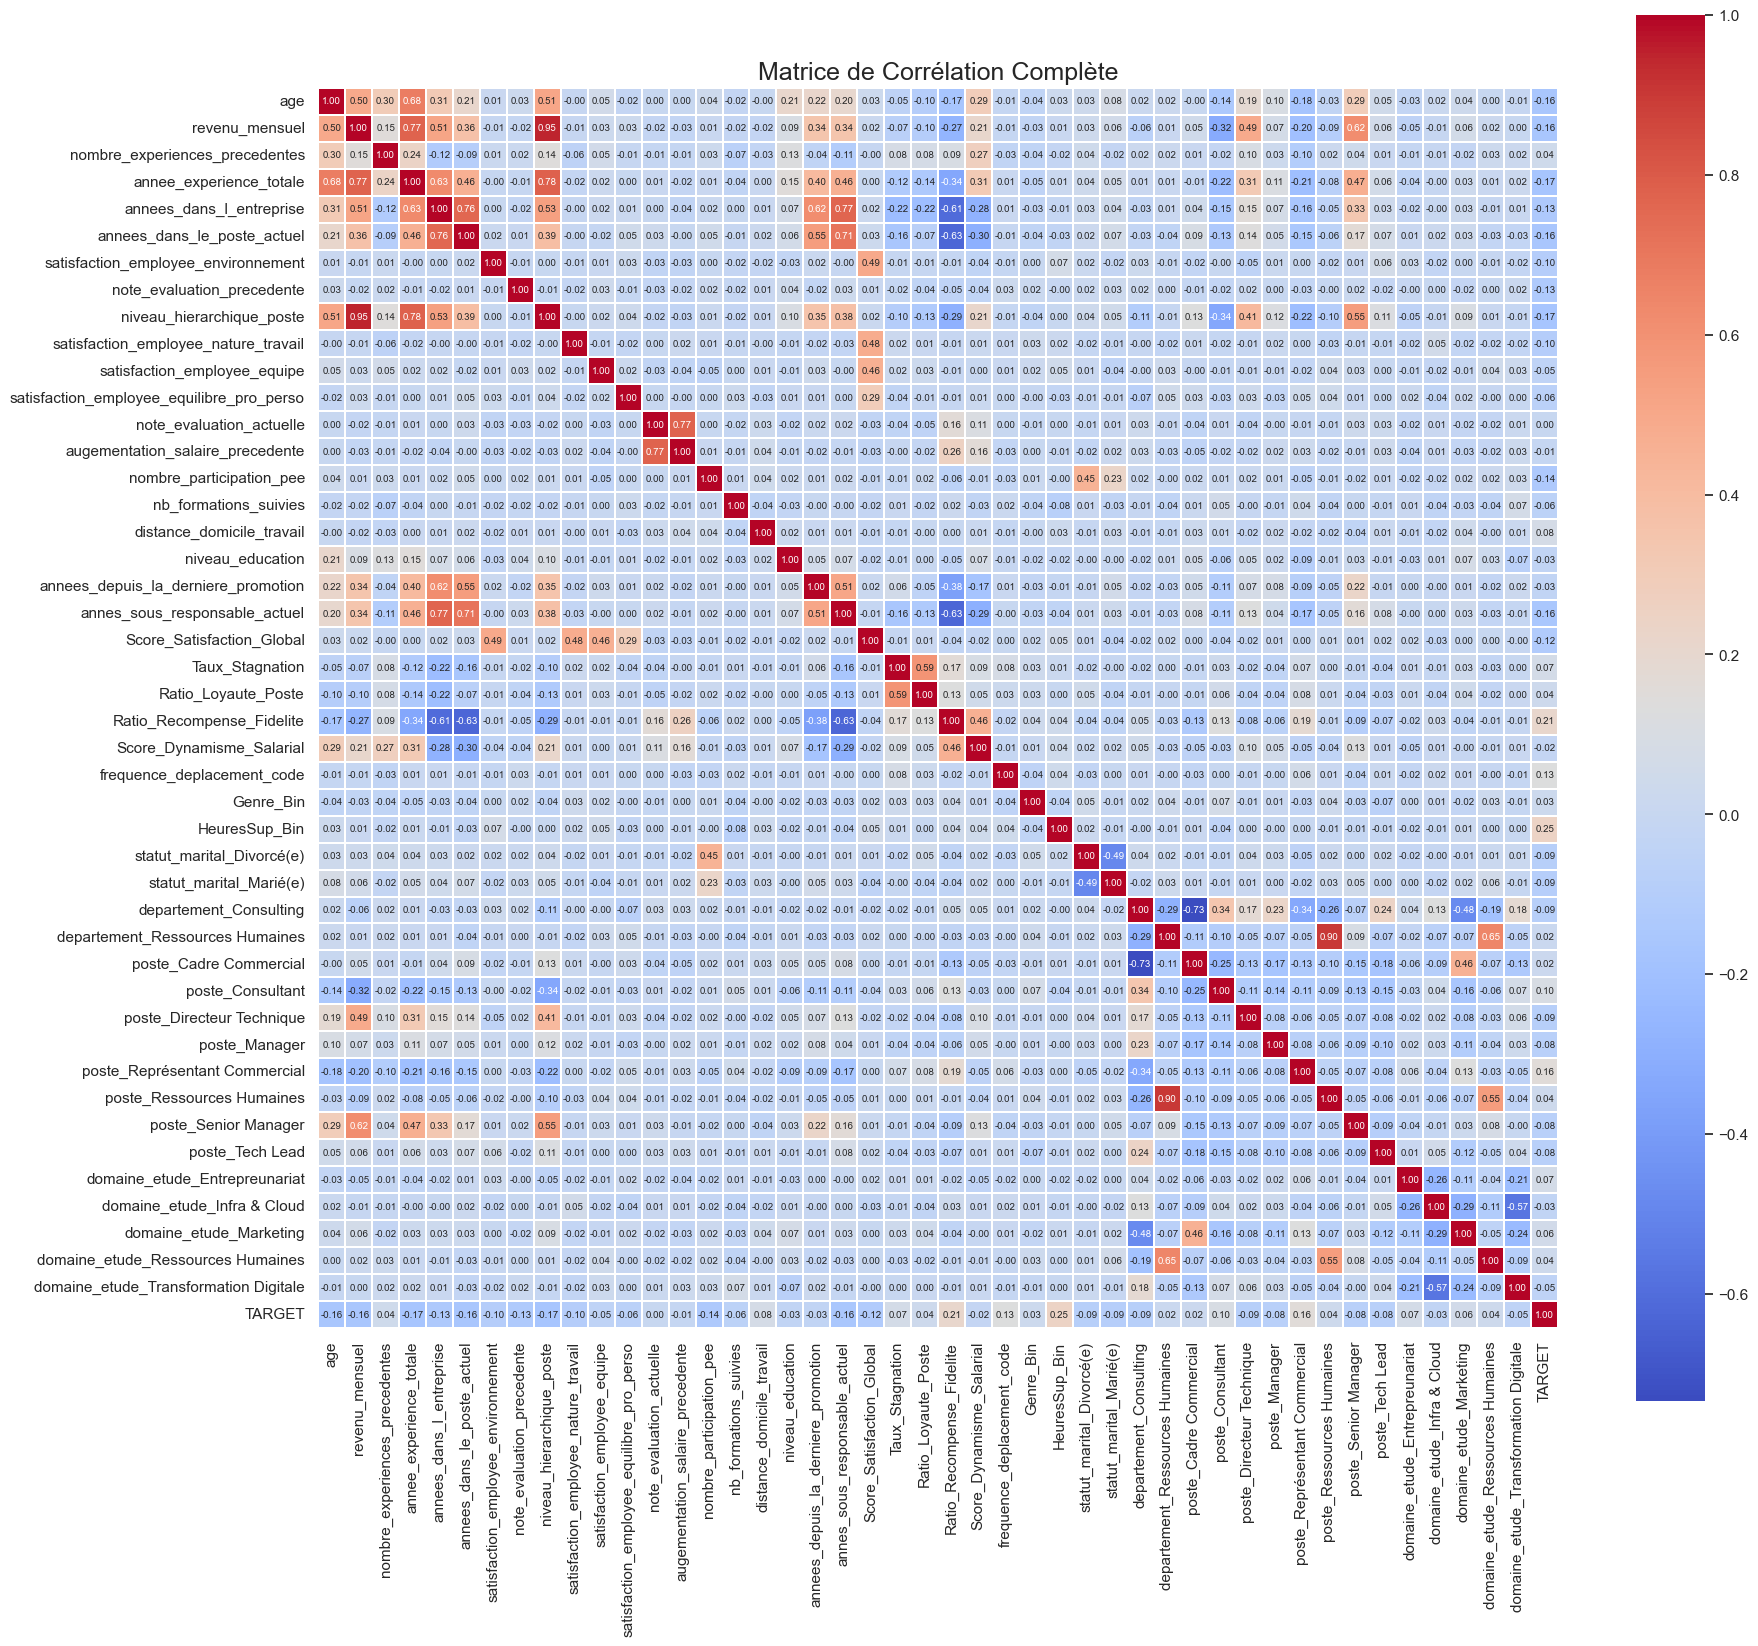

In [18]:
# 1. Préparation du DataFrame complet
df_full_corr = pd.concat([X_encoded, y], axis=1)

# 2. Calcul de la corrélation totale
full_matrix = df_full_corr.corr()

# 3. Affichage de la matrice complète
# On augmente la taille à (20, 18) pour que les noms ne se chevauchent pas
plt.figure(figsize=(20, 18))

sns.heatmap(
    full_matrix, 
    annot=True,           # Affiche les chiffres
    annot_kws={"size": 7}, # Réduit la taille des chiffres pour qu'ils rentrent dans les cases
    cmap='coolwarm', 
    fmt=".2f", 
    linewidths=0.1, 
    square=True
)
# bbox_inches='tight' est crucial ici pour ne pas couper les textes longs à gauche
plt.savefig("matrice_correlation.png", dpi=300, bbox_inches='tight')

plt.title("Matrice de Corrélation Complète", fontsize=18)
plt.show()

